In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import extract

In [5]:
# Create our engine aka where the data is being pulled
engine = create_engine("sqlite:///../Resources/hawaii.sqlite", echo = False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Print the first row in the Measurement table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x18bf91ff708>,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [11]:
# Print the first row in the Station table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x18bf9280788>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# First Step in getting last 12 months of data. 
last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("The latest date was " + str(last_data_point) + ".")

The latest date was ('2017-08-23',).


In [13]:
# Second Step in getting last 12 months of data. 
### If you remove '.limit(10)' you can see the full 12 months. I am simply saving scroll time.
last_twelve_months = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).all()
last_twelve_months

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [14]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago_from_last_datapoint = session.query(Measurement.date).\
filter(Measurement.date == '2016-08-23').first()
print("One year ago was " + str(one_year_ago_from_last_datapoint) + ".")

One year ago was ('2016-08-23',).


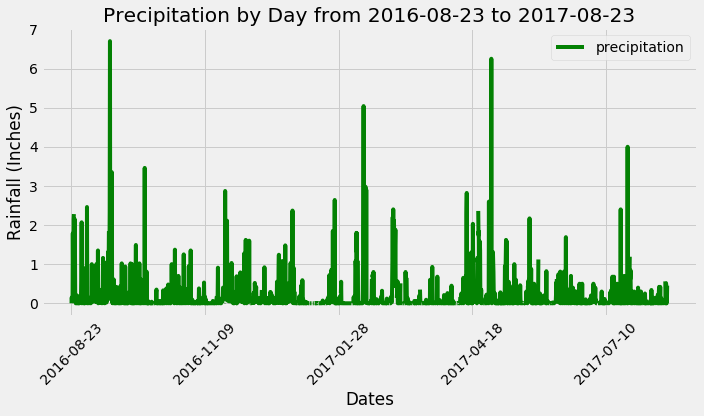

In [15]:
# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
last_twelve_months_df = pd.DataFrame(last_twelve_months, 
                                     columns=["date", "precipitation"]).set_index("date")
last_twelve_months_df
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
x_values = last_twelve_months_df.index
y_values = last_twelve_months_df["precipitation"]

last_twelve_months_df.plot(rot = 45, alpha = 0.99, color = 'g', figsize = (10, 6), legend = True)
plt.title("Precipitation by Day from 2016-08-23 to 2017-08-23")
plt.ylabel("Rainfall (Inches)")
plt.xlabel("Dates")
plt.tight_layout()
plt.savefig('../Images/last_twelve_months_precipitation.png')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_statistics_precipitation_data = last_twelve_months_df.describe()
summary_statistics_precipitation_data

precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

In [17]:
# Design a query to show how many stations are available in this dataset?
number_of_stations_in_Measurement_dataset = session.query(Measurement.station).count()
print("There are " + str(number_of_stations_in_Measurement_dataset) + " available stations in the Measurement dataset.")

There are 19550 available stations in the Measurement dataset.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stats_of_most_active_stations_plural = session.query(Measurement.station, 
                                            func.count(Measurement.station),
                                            func.min(Measurement.tobs), 
                                            func.max(Measurement.tobs), 
                                            func.avg(Measurement.tobs)).\
                                    group_by(Measurement.station).\
                                    order_by(func.count(Measurement.station).desc()).all()
stats_of_most_active_stations_plural

[('USC00519281', 2772, 54.0, 85.0, 71.66378066378067),
 ('USC00519397', 2724, 56.0, 87.0, 74.55323054331865),
 ('USC00513117', 2709, 59.0, 85.0, 72.68918420081211),
 ('USC00519523', 2669, 56.0, 85.0, 74.5436493068565),
 ('USC00516128', 2612, 58.0, 84.0, 70.91500765696784),
 ('USC00514830', 2202, 58.0, 85.0, 74.8732970027248),
 ('USC00511918', 1979, 53.0, 87.0, 71.61596766043456),
 ('USC00517948', 1372, 58.0, 87.0, 74.68440233236151),
 ('USC00518838', 511, 58.0, 83.0, 72.72407045009784)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stats_of_most_active_station = session.query(Measurement.station, 
                                    func.count(Measurement.station),
                                    func.min(Measurement.tobs), 
                                    func.max(Measurement.tobs), 
                                    func.avg(Measurement.tobs)).\
                                    group_by(Measurement.station).\
                                    order_by(func.count(Measurement.station).desc()).first()
stats_of_most_active_station

('USC00519281', 2772, 54.0, 85.0, 71.66378066378067)

In [20]:
# Choose the station with the highest number of temperature observations.
most_active_station = session.query(Measurement.station, 
                                    func.count(Measurement.tobs)).\
                                    group_by(Measurement.station).\
                                    order_by(func.count(Measurement.tobs).desc()).first()
most_active_station

('USC00519281', 2772)

In [21]:
# Query the last 12 months of temperature observation data for this station
last_twelve_months_for_USC00519281 = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
filter(Measurement.date >= '2016-08-23').\
filter(Measurement.station == most_active_station[0]).\
    group_by(Measurement.date).\
    order_by(Measurement.date.desc()).all()
last_twelve_months_for_USC00519281

[('2017-08-18', 'USC00519281', 79.0),
 ('2017-08-17', 'USC00519281', 76.0),
 ('2017-08-16', 'USC00519281', 76.0),
 ('2017-08-15', 'USC00519281', 77.0),
 ('2017-08-14', 'USC00519281', 77.0),
 ('2017-08-13', 'USC00519281', 77.0),
 ('2017-08-06', 'USC00519281', 83.0),
 ('2017-08-05', 'USC00519281', 82.0),
 ('2017-08-04', 'USC00519281', 77.0),
 ('2017-07-31', 'USC00519281', 76.0),
 ('2017-07-30', 'USC00519281', 81.0),
 ('2017-07-29', 'USC00519281', 82.0),
 ('2017-07-28', 'USC00519281', 81.0),
 ('2017-07-27', 'USC00519281', 76.0),
 ('2017-07-26', 'USC00519281', 75.0),
 ('2017-07-25', 'USC00519281', 77.0),
 ('2017-07-24', 'USC00519281', 75.0),
 ('2017-07-23', 'USC00519281', 82.0),
 ('2017-07-22', 'USC00519281', 77.0),
 ('2017-07-21', 'USC00519281', 77.0),
 ('2017-07-20', 'USC00519281', 77.0),
 ('2017-07-19', 'USC00519281', 76.0),
 ('2017-07-18', 'USC00519281', 76.0),
 ('2017-07-17', 'USC00519281', 76.0),
 ('2017-07-16', 'USC00519281', 80.0),
 ('2017-07-15', 'USC00519281', 80.0),
 ('2017-07-1

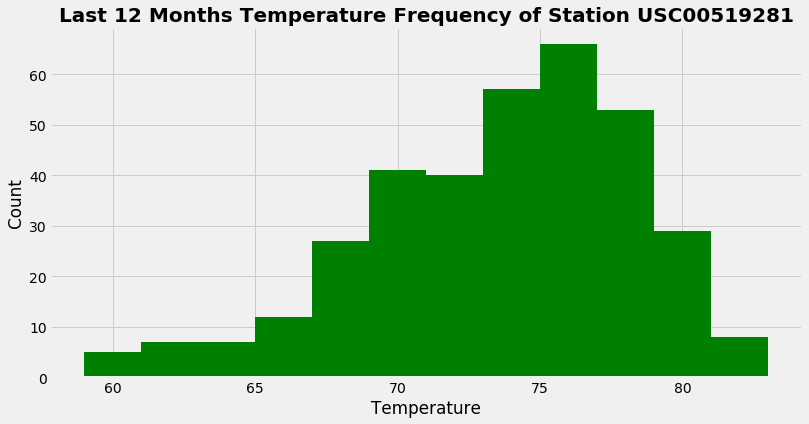

In [22]:
# Plot the results as a histogram
last_twelve_months_for_USC00519281_df = pd.DataFrame(last_twelve_months_for_USC00519281)
last_twelve_months_for_USC00519281_df

last_twelve_months_for_USC00519281_df.plot.hist(bins=12, figsize = (12, 6), color = 'g', legend = False)
plt.title("Last 12 Months Temperature Frequency of Station USC00519281", fontsize = 20, fontweight = 'bold')
plt.xlabel("Temperature")
plt.ylabel("Count")
plt.savefig('../Images/last_twelve_months_for_USC00519281_histogram.png')
plt.show()

# Bonus Challenge #1 

In [23]:
# Measurements File to Load 
hawaii_measurements = "../Resources/hawaii_measurements.csv"

# Read Hawaii Measurements File and store into Pandas DataFrame
hawaii_measurements_df = pd.read_csv(hawaii_measurements)
hawaii_measurements_df.head()

station        date  prcp  tobs
0  USC00519397  2010-01-01  0.08    65
1  USC00519397  2010-01-02  0.00    63
2  USC00519397  2010-01-03  0.00    74
3  USC00519397  2010-01-04  0.00    76
4  USC00519397  2010-01-06   NaN    73

In [24]:
# Stations File to Load
hawaii_stations = "../Resources/hawaii_stations.csv"

# Read Hawaii Stations File and store into Pandas DataFrame
hawaii_stations_df = pd.read_csv(hawaii_stations)
hawaii_stations_df.head()

station                                    name  latitude  longitude  \
0  USC00519397                    WAIKIKI 717.2, HI US   21.2716  -157.8168   
1  USC00513117                    KANEOHE 838.1, HI US   21.4234  -157.8015   
2  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US   21.5213  -157.8374   
3  USC00517948                       PEARL CITY, HI US   21.3934  -157.9751   
4  USC00518838              UPPER WAHIAWA 874.3, HI US   21.4992  -158.0111   

   elevation  
0        3.0  
1       14.6  
2        7.0  
3       11.9  
4      306.6

In [25]:
# Merge the two DFs 
merged_stations_and_measurements_df = pd.merge(hawaii_stations_df, hawaii_measurements_df, on = 'station', how = 'left')
merged_stations_and_measurements_df

station                          name  latitude  longitude  \
0      USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
1      USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
2      USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
3      USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
4      USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
...            ...                           ...       ...        ...   
19545  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   
19546  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   
19547  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   
19548  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   
19549  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   

       elevation        date  prcp  tobs  
0            3.0  2010-01-01  0.08    65  
1            3.0  2010-01-02  0.00    63  
2            3.0  2010-01-03  0.00    74  
3            3.0  2010-01-04  0.00    76  
4            3.0  2010-01-06   NaN    73  
...          ...         ...   ...   ...  
19545      152.4  2017-08-19  0.09    71  
19546      152.4  2017-08-20   NaN    78  
19547      152.4  2017-08-21  0.56    76  
19548      152.4  2017-08-22  0.50    76  
19549      152.4  2017-08-23  0.45    76  

[19550 rows x 8 columns]

In [26]:
# Use the newly merged DF to fetch data by a specific month
merged_stations_and_measurements_df['month'] = pd.DatetimeIndex(merged_stations_and_measurements_df['date']).month
merged_stations_and_measurements_df

# Fetch June Data
june = merged_stations_and_measurements_df.loc[merged_stations_and_measurements_df['month'] == 6]
june

station                          name  latitude  longitude  \
133    USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
134    USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
135    USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
136    USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
137    USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
...            ...                           ...       ...        ...   
19492  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   
19493  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   
19494  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   
19495  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   
19496  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   

       elevation        date  prcp  tobs  month  
133          3.0  2010-06-01  0.00    78      6  
134          3.0  2010-06-02  0.01    76      6  
135          3.0  2010-06-03  0.00    78      6  
136          3.0  2010-06-04  0.00    76      6  
137          3.0  2010-06-05  0.00    77      6  
...          ...         ...   ...   ...    ...  
19492      152.4  2017-06-26  0.02    79      6  
19493      152.4  2017-06-27  0.10    74      6  
19494      152.4  2017-06-28  0.02    74      6  
19495      152.4  2017-06-29  0.04    76      6  
19496      152.4  2017-06-30  0.20    75      6  

[1700 rows x 9 columns]

In [27]:
# Fetch December Data
december = merged_stations_and_measurements_df.loc[merged_stations_and_measurements_df['month'] == 12]
december

station                          name  latitude  longitude  \
305    USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
306    USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
307    USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
308    USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
309    USC00519397          WAIKIKI 717.2, HI US   21.2716  -157.8168   
...            ...                           ...       ...        ...   
19323  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   
19324  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   
19325  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   
19326  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   
19327  USC00516128  MANOA LYON ARBO 785.2, HI US   21.3331  -157.8025   

       elevation        date  prcp  tobs  month  
305          3.0  2010-12-01  0.04    76     12  
306          3.0  2010-12-03  0.00    74     12  
307          3.0  2010-12-04  0.00    74     12  
308          3.0  2010-12-06  0.00    64     12  
309          3.0  2010-12-07  0.00    64     12  
...          ...         ...   ...   ...    ...  
19323      152.4  2016-12-27  0.14    71     12  
19324      152.4  2016-12-28  0.14    71     12  
19325      152.4  2016-12-29  1.03    69     12  
19326      152.4  2016-12-30  2.37    65     12  
19327      152.4  2016-12-31  0.90    65     12  

[1517 rows x 9 columns]

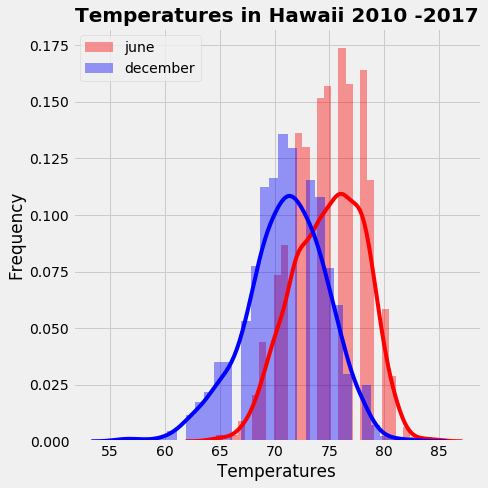

In [28]:
# Create a distribution curve to give us a better representation of future temperature predictions for
# the months of June and December in Hawaii. This helps us analyze a conclusion noting if there
# are any major differences in temps during these two months.

f, axes = plt.subplots(1,1, figsize=(7, 7), sharex=True)

sb.distplot(june['tobs'], color="red", label = 'june')
sb.distplot(december['tobs'], color="blue", label = 'december')

plt.title('Temperatures in Hawaii 2010 -2017', fontsize = 20, fontweight = 'bold')
plt.xlabel('Temperatures')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('../Images/temps_in_hawaii_2010_until_2017.png')
plt.show()

In [29]:

clean_june_group = june.groupby(["station"])
clean_june_group

avg_temp = round(clean_june_group["tobs"].mean(), 2)
avg_temp

avg_june_temp_df = pd.DataFrame({'Avg. Temp': avg_temp})
avg_june_temp_df

Avg. Temp
station               
USC00511918      74.14
USC00513117      74.05
USC00514830      76.01
USC00516128      71.94
USC00517948      76.66
USC00518838      73.39
USC00519281      73.27
USC00519397      77.56
USC00519523      76.67

In [30]:
# Here we find the avg. Temps for each station in December

clean_december_group = december.groupby(["station"])
clean_december_group

avg_temp = round(clean_december_group["tobs"].mean(), 2)
avg_temp

avg_december_temp_df = pd.DataFrame({'Avg. Temp': avg_temp})
avg_december_temp_df

Avg. Temp
station               
USC00511918      69.68
USC00513117      71.07
USC00514830      73.22
USC00516128      69.29
USC00517948      71.83
USC00518838      72.42
USC00519281      69.90
USC00519397      71.11
USC00519523      72.43

In [31]:
# This summarizes our statistics for further analysis. For example we could create
# a box and whisker between the upper and lower quartiles to compare with another month.

avg_december_temp_df_stats = avg_december_temp_df.describe()
avg_december_temp_df_stats

Avg. Temp
count   9.000000
mean   71.216667
std     1.376118
min    69.290000
25%    69.900000
50%    71.110000
75%    72.420000
max    73.220000

In [32]:
# We can compare these stats with Decembers stats.
avg_june_temp_df_stats = avg_june_temp_df.describe()
avg_june_temp_df_stats

Avg. Temp
count   9.000000
mean   74.854444
std     1.920879
min    71.940000
25%    73.390000
50%    74.140000
75%    76.660000
max    77.560000

Assuming a paired t-test and a significance level of 0.05 - From 2010 -2017, June had a mean temperature of 74.85 degrees Fahrenheit while December had a mean temperature of 71.22. The Standard Deviation was 1.921 and 1.377 respectively with 1700 and 1517 datapoints respectively as well. After finding our t-value of 62.09 we concurred the the probability was very close to 1. After comparing our probability (p-value) to our significance level of 0.05 we see that our p-value is significantly greater than 0.05 suggesting that the mean on June and the Mean of December has no difference in temperatures between the two months. This further alsos us to accept the null hypothesis (assuming all conditions for inference are met).

## Bonus Challenge Assignment

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-04-28', '2012-05-05'))

[(66.0, 72.25, 78.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2010-07-04', '2010-07-11'))

[(68.0, 73.73846153846154, 81.0)]


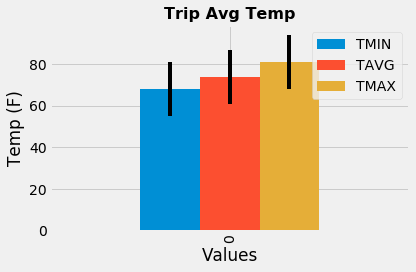

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_trip_previous_year = calc_temps('2010-07-04', '2010-07-11')
my_trip_previous_year

my_trip_previous_year_df = pd.DataFrame(my_trip_previous_year, columns = ['TMIN', 'TAVG', 'TMAX'])
my_trip_previous_year_df

error = my_trip_previous_year_df['TMAX'] - my_trip_previous_year_df['TMIN']

my_trip_previous_year_df.plot(kind = 'bar', yerr=error)
plt.title("Trip Avg Temp", fontsize = 16, fontweight = 'bold')
plt.ylabel("Temp (F)")
plt.xlabel("Values")
plt.tight_layout()
plt.savefig('../Images/previous_year_vacation_date_avg_temps.png')
plt.show()

In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2010-07-04'
end_date = '2010-07-11'

total_rainfall_per_station_previous_year = session.query(Measurement.station, Measurement.prcp, 
                                                         Station.name, Station.latitude, Station.longitude, 
                                                         Station.elevation).\
filter(Measurement.date >= start_date).\
filter(Measurement.date <= end_date).\
    order_by(Measurement.prcp.desc()).all()
total_rainfall_per_station_previous_year


[('USC00516128', 1.05, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00516128', 1.05, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00516128',
  1.05,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128', 1.05, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00516128',
  1.05,
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6),
 ('USC00516128',
  1.05,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00516128',
  1.05,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00516128',
  1.05,
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9),
 ('USC00516128',
  1.05,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00516128', 1.01, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00516128', 1.01, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00516128',
  1.01,
  'KUALOA RANCH HEADQUARTERS 886.9,

In [37]:
# Plot the precipitation totals from lowest to highest. 
total_rainfall_per_station_previous_year = pd.DataFrame(total_rainfall_per_station_previous_year, columns = ['station', 
                                                                                                            'prcp',
                                                                                                            'station name',
                                                                                                            'lat',
                                                                                                            'long.',
                                                                                                            'elevation'])
total_rainfall_per_station_previous_year


station  prcp                            station name       lat  \
0    USC00516128  1.05                    WAIKIKI 717.2, HI US  21.27160   
1    USC00516128  1.05                    KANEOHE 838.1, HI US  21.42340   
2    USC00516128  1.05  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130   
3    USC00516128  1.05                       PEARL CITY, HI US  21.39340   
4    USC00516128  1.05              UPPER WAHIAWA 874.3, HI US  21.49920   
..           ...   ...                                     ...       ...   
580  USC00518838   NaN              UPPER WAHIAWA 874.3, HI US  21.49920   
581  USC00518838   NaN      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556   
582  USC00518838   NaN                     WAIHEE 837.5, HI US  21.45167   
583  USC00518838   NaN       HONOLULU OBSERVATORY 702.2, HI US  21.31520   
584  USC00518838   NaN            MANOA LYON ARBO 785.2, HI US  21.33310   

         long.  elevation  
0   -157.81680        3.0  
1   -157.80150       14.6  
2   -157.83740        7.0  
3   -157.97510       11.9  
4   -158.01110      306.6  
..         ...        ...  
580 -158.01110      306.6  
581 -157.71139       19.5  
582 -157.84889       32.9  
583 -157.99920        0.9  
584 -157.80250      152.4  

[585 rows x 6 columns]

In [38]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("07-04")

[(70.0, 76.57142857142857, 81.0)]

In [39]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = '2010-07-04'
end_date = '2010-07-11'
# Use the start and end date to create a range of dates
vacation_date_range = pd.date_range(start =start_date, end = end_date).strftime("%m-%d")
# Strip off the year and save a list of %m-%d strings
vacation_date_range
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in vacation_date_range:
    dates = {}
    norm = daily_normals(date)
    dates["Date"] = date
    dates["Min"] = norm[0][0]
    dates["Avg"] = norm[0][1]
    dates["Max"] = norm[0][2]

    normals.append(dates)
    
normals

[{'Date': '07-04', 'Min': 70.0, 'Avg': 76.57142857142857, 'Max': 81.0},
 {'Date': '07-05', 'Min': 66.0, 'Avg': 75.0, 'Max': 81.0},
 {'Date': '07-06', 'Min': 69.0, 'Avg': 75.0, 'Max': 81.0},
 {'Date': '07-07', 'Min': 69.0, 'Avg': 74.91071428571429, 'Max': 82.0},
 {'Date': '07-08', 'Min': 69.0, 'Avg': 76.08333333333333, 'Max': 83.0},
 {'Date': '07-09', 'Min': 68.0, 'Avg': 76.19298245614036, 'Max': 83.0},
 {'Date': '07-10', 'Min': 68.0, 'Avg': 75.62068965517241, 'Max': 82.0},
 {'Date': '07-11', 'Min': 70.0, 'Avg': 75.78947368421052, 'Max': 81.0}]

In [40]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
previous_year_vacation_date_normals = pd.DataFrame(normals).set_index('Date')
previous_year_vacation_date_normals

Min        Avg   Max
Date                        
07-04  70.0  76.571429  81.0
07-05  66.0  75.000000  81.0
07-06  69.0  75.000000  81.0
07-07  69.0  74.910714  82.0
07-08  69.0  76.083333  83.0
07-09  68.0  76.192982  83.0
07-10  68.0  75.620690  82.0
07-11  70.0  75.789474  81.0

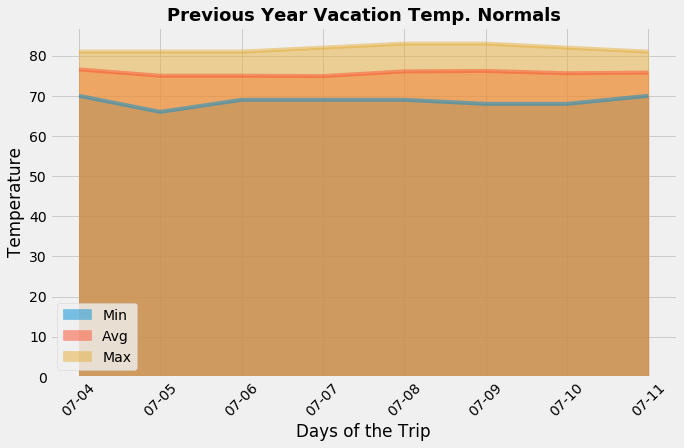

In [41]:
# Plot the daily normals as an area plot with `stacked=False`
previous_year_vacation_date_normals.plot(kind = 'area', rot = 45, figsize = (10, 6), stacked = False)
plt.title("Previous Year Vacation Temp. Normals", fontsize = 18, fontweight = 'bold')
plt.xlabel("Days of the Trip")
plt.ylabel("Temperature")
plt.savefig('../Images/previous_year_vacation_date_normals.png')
plt.show()